In [30]:
import h5py as h5
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
from scipy import stats

# Load data and background

In [31]:
# Load data for energy efficiency
source_file = "/reg/d/psdm/xpp/xppx40318/hdf5/smalldata/xppx40318_Run025.h5"
with h5.File(source_file,'r') as source:
    #print(list(source.keys()))
    upstream_intensity = np.array(source['ipm2/sum'])    
    
    #print(list(source["zyla_0"].keys()))
    zyla_sum = np.array(source['zyla_0/ROI0_sum'])
    
max_idx = np.argmax(zyla_sum)

with h5.File(source_file,'r') as source:
    max_pattern = np.array(source['zyla_0/ROI0_area'][max_idx])

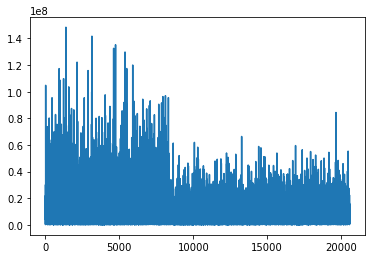

In [32]:
plt.plot(zyla_sum)
plt.show()

# Find max pattern such that the pattern index is larger than 10000

In [33]:
max_idx_new = np.argmax(zyla_sum[10000:])
max_idx_new += 10000

with h5.File(source_file,'r') as source:
    pattern_max_new = np.array(source['zyla_0/ROI0_area'][max_idx_new])

In [34]:
# Find patterns with large zyla values to reduce variance
mask = np.zeros_like(zyla_sum, dtype=np.bool)
mask[zyla_sum>1000000] = True

idx_with_mask = np.arange(zyla_sum.shape[0])[mask]

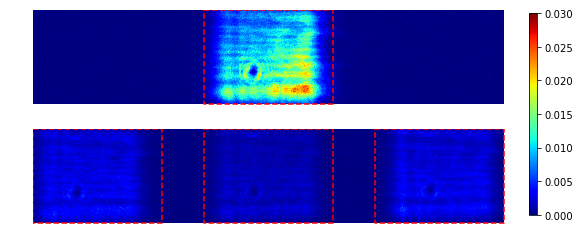

In [46]:
fig, axes = plt.subplots(nrows = 2, ncols = 1)

fig.set_figheight(4)
fig.set_figwidth(12)

max_val = 3e-2
img1 = axes[0].imshow(max_pattern / upstream_intensity[max_idx], cmap="jet", vmax=max_val, vmin=0)
axes[0].set_axis_off()
axes[0].plot([0, 700, 700, 0, 0],
             [0,0, 512, 512,0], 'b--', alpha=0)

axes[0].plot([1860, 2560, 2560, 1860, 1860],
             [0,0, 512, 512,0], 'b--', alpha=0.)

axes[0].plot([930, 1630, 1630, 930, 930],
             [0,0, 512, 512,0], 'r--')


img2 = axes[1].imshow(pattern_max_new / upstream_intensity[max_idx_new], cmap="jet", vmax=max_val, vmin=0)
axes[1].set_axis_off()

axes[1].plot([0, 700, 700, 0, 0],
             [0,0, 512, 512,0], 'r--')

axes[1].plot([930, 1630, 1630, 930, 930],
             [0,0, 512, 512,0], 'r--')

axes[1].plot([1860, 2560, 2560, 1860, 1860],
             [0,0, 512, 512,0], 'r--')

fig.subplots_adjust(right=0.7)
cbar_ax = fig.add_axes([0.7, 0.17, 0.01, 0.7])
fig.colorbar(img1, cax=cbar_ax)

plt.savefig("./grating_region.png", dpi=300, facecolor='w', edgecolor='w',
        orientation='portrait', papertype=None, format=None,
        transparent=True, bbox_inches=0, pad_inches=0.0,
        frameon=None,)
plt.show()

# Calculate the beam intensity and the efficiency

In [25]:
with h5.File(source_file,'r') as source:
    intensity_all = np.sum(np.array(source['zyla_0/ROI0_area'][5000:8000, :, 930:1630]), 
                           axis=(1,2))
    intensity_1 = np.sum(np.array(source['zyla_0/ROI0_area'][10000:13000, :, 0:700]), 
                           axis=(1,2))
    intensity_2 = np.sum(np.array(source['zyla_0/ROI0_area'][10000:13000, :, 1860:]), 
                           axis=(1,2))
    intensity_3 = np.sum(np.array(source['zyla_0/ROI0_area'][10000:13000, :, 930:1630]), 
                           axis=(1,2))

# Calculate the slope 

In [27]:
curve_fit_all =  stats.linregress(x=upstream_intensity[5000:8000], y=intensity_all)
curve_fit_1 =   stats.linregress(x=upstream_intensity[10000:13000], y=intensity_1)
curve_fit_2 =   stats.linregress(x=upstream_intensity[10000:13000], y=intensity_2)
curve_fit_3 =   stats.linregress(x=upstream_intensity[10000:13000], y=intensity_3)

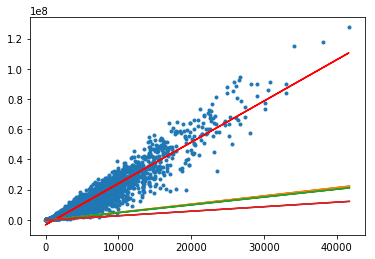

In [28]:
plt.plot(upstream_intensity[5000:8000], intensity_all, '.')
plt.plot(upstream_intensity[5000:8000], upstream_intensity[5000:8000] * curve_fit_all.slope + curve_fit_all.intercept, 'r-')

plt.plot(upstream_intensity[10000:13000], upstream_intensity[10000:13000] * curve_fit_1.slope + curve_fit_1.intercept)
plt.plot(upstream_intensity[10000:13000], upstream_intensity[10000:13000] * curve_fit_2.slope + curve_fit_2.intercept)

plt.plot(upstream_intensity[10000:13000], upstream_intensity[10000:13000] * curve_fit_3.slope + curve_fit_3.intercept)


plt.show()

In [29]:
def get_efficiency_and_uncertainty(direct_beam, diffraction):
    
    # Get efficiency
    _efficiency = diffraction.slope / direct_beam.slope
    print("The energy efficiency is {:.1f}%".format(_efficiency * 100))
    
    # Get the relative efficiency of the efficiency
    relative_std = (diffraction.stderr / diffraction.slope) ** 2
    relative_std += (direct_beam.stderr / direct_beam.slope) ** 2
    relative_std = np.sqrt(relative_std)
    
    # Get the uncertainty of the efficiency
    _eff_std = _efficiency * relative_std
    
    print("The standard deviation of the efficiency is {:.1f}%".format(100 * _eff_std))
    
# Calculate the efficiency and the corresponding uncertainty
get_efficiency_and_uncertainty(curve_fit_all, curve_fit_1)
get_efficiency_and_uncertainty(curve_fit_all, curve_fit_2)
get_efficiency_and_uncertainty(curve_fit_all, curve_fit_3)

The energy efficiency is 20.0%
The standard deviation of the efficiency is 0.2%
The energy efficiency is 19.0%
The standard deviation of the efficiency is 0.2%
The energy efficiency is 11.0%
The standard deviation of the efficiency is 0.1%
